In [1]:
# d6623
# Generate a model that classifies card values, from the images created
# Uses images in suits/train and suits/test (but test is not added yet)
# Heavily "inspired" by catsvdogs model from keras

# Flow
# 1. Load all the data
# 2. Train on model

import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

base_dir = '/Users/James/Projects/PycharmProjects/jerry/cards'
train_dir = os.path.join(base_dir, 'value/train')
val_dir = os.path.join(base_dir, 'value/val')

In [2]:
def value_to_label(val):
    # Cause its really weird the order goes backwards
    # 10, 11, 12, 13, 1, 2, 3, 4, 5, 6, 7, 8, 9
    labels = [1, 10, 11, 12, 13, 2, 3, 4, 5, 6, 7, 8, 9]
    return labels[val]

train_datagen = ImageDataGenerator(rescale=1./255,  # Just to add some more datapoints
                                   brightness_range=[0.2, 2],
                                   shear_range=10.0,
                                   zoom_range=[.9, 1.1],
                                   rotation_range=5)

val_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 5
print("Making training generator")
train_generator = train_datagen.flow_from_directory(train_dir,
                                        target_size=(150,150),
                                        batch_size=batch_size,
                                        color_mode='grayscale',
                                        class_mode='categorical')

print("Making validation generator")
val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(150, 150),
                                                batch_size=batch_size,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Making training generator
Found 78 images belonging to 13 classes.
Making validation generator
Found 26 images belonging to 13 classes.


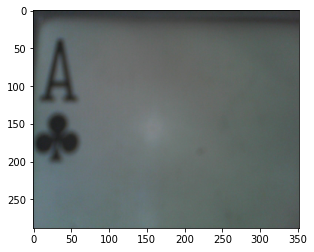

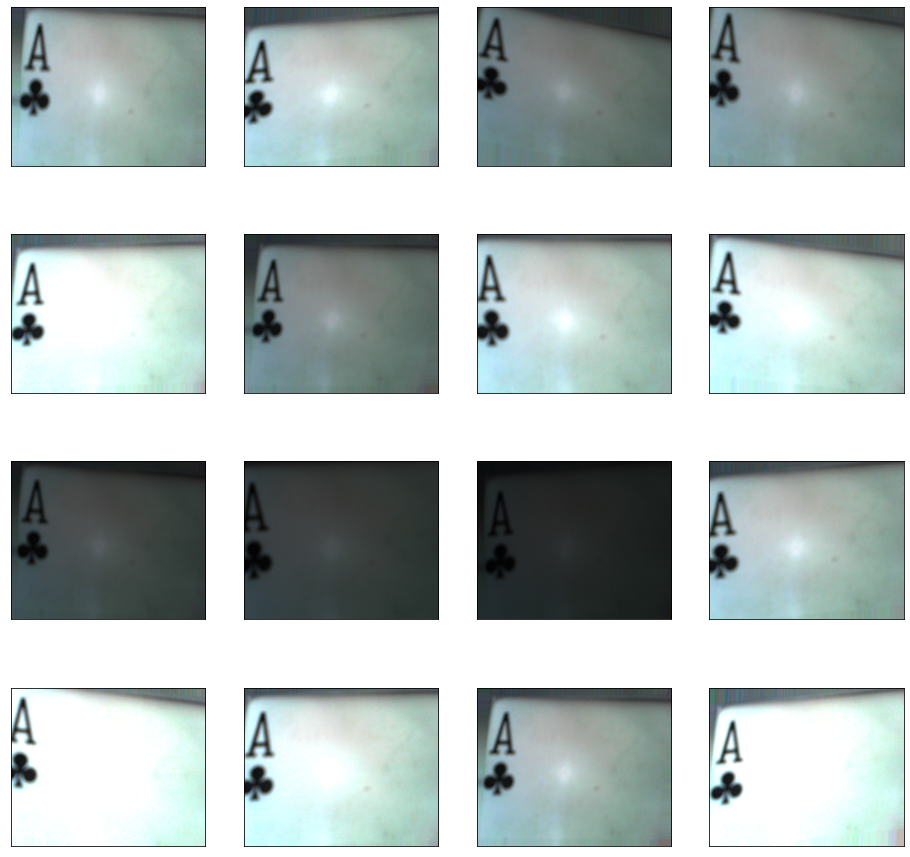

In [3]:
# Load some example data
img = plt.imread(os.path.join(train_dir, "1/club_0.jpg"))
plt.imshow(img)

img = np.expand_dims(img, axis=0)
ex_datagen = train_datagen
ex_datagen.fit(img)

plt.figure(figsize=(16,16))
it = ex_datagen.flow(img)
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(it.next().reshape(288,352, 3))  # Lol that reshape was a total guess
plt.show()


Sample of example input train image


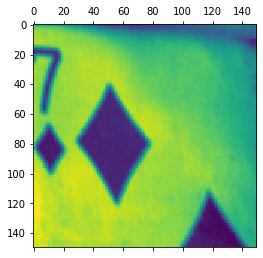

label of 7
Shape of (5, 150, 150, 1)

Sample of example input validation image
(150, 150, 1)


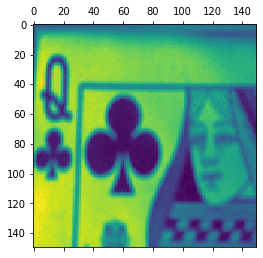

label of 12
Shape of (5, 150, 150, 1)


In [4]:
length = 104  # how far to cycle to see every image
print('\nSample of example input train image')
for inputs_batch, labels_batch in train_generator:
    plt.matshow(inputs_batch[0].reshape(150,150))
    plt.show()

    print('label of', value_to_label(labels_batch[0].argmax(axis=0)))
    print('Shape of', inputs_batch.shape)
    break

print('\nSample of example input validation image')
for inputs_batch, labels_batch in val_generator:
    print(inputs_batch[0].shape)
    plt.matshow(inputs_batch[0].reshape(150,150))
    plt.show()

    print('label of', value_to_label(labels_batch[0].argmax(axis=0)))
    print('Shape of', inputs_batch.shape)
    break

# I think the error is coming from the connection between the data and the model.
# Test that the input matrix and channels in the model is the same dims

In [5]:
from keras import layers, optimizers
from keras.models import Sequential

# Probably too complex for this situiation, but I don't care
model = Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,1)))
model.add(layers.MaxPooling2D((3,3)))  # Make the view larger; find bigger patterns

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())  # Dimension reduce
model.add(layers.Dropout(0.5))  # Get rid of conspiracies
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(13, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0

In [14]:
from time import time
start = time()
history = model.fit(train_generator,
                              steps_per_epoch=15,  # 10 * 10 = 100 from 104 samples
                              epochs=200,
                              validation_data=val_generator,
                              validation_steps=5,
                              verbose=0)  # total of 128*100=12800 samples used
print('Took',(time()-start).__round__(4),'seconds to train the network')

Took 294.2923 seconds to train the network


In [20]:
# save the model
print('Saving model...')
model.save('value-v3.h5')
print('Saved.')

Saving model...
Saved.


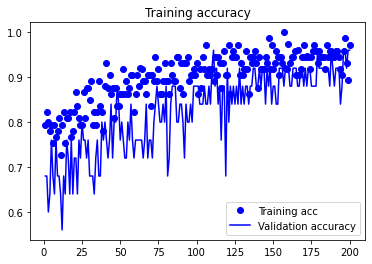

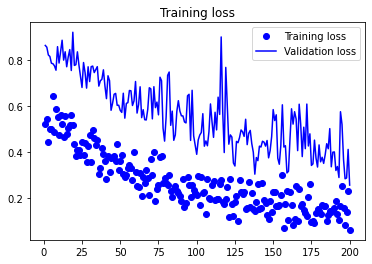

In [15]:
# Visualise the training data
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training accuracy')
plt.legend()

plt.figure()  # Combines the two graphs

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [19]:
# Test on custom image
from keras.preprocessing import image

number_to_test = '11'
print('Testing against num', number_to_test)

dir = os.path.join(val_dir, number_to_test)
print("Using dir", val_dir)
fnames = []
for fname in os.listdir(dir):
    if fname != '.DS_Store':
        fnames.append(os.path.join(dir, fname))

for img_path in fnames:
    img = image.load_img(img_path,
                         target_size=(150,150),
                         color_mode='grayscale')

    x = image.img_to_array(img)
    x = x.astype('float32')/255
    x = x.reshape((1,) + x.shape)  # Convert from (150,150,1) to (1,150,150,1)

    pred = model.predict(x, verbose=0)
    pred = pred.reshape(13)

    print("\nPrediction of", value_to_label(pred.argmax(axis=0)))
    print("With certainty of", pred[pred.argmax(axis=0)].__round__(2))

#plt.imshow(img)
#plt.show()

Testing against num 11
Using dir /Users/James/Projects/PycharmProjects/jerry/cards/value/val

Prediction of 11
With certainty of 1.0

Prediction of 11
With certainty of 1.0
